In [1]:
# Task 1.
# Текстурные характеристики:
#  - Реализуйте подсчет гистограммы 
#  - Реализуйте рассчет текстурных характеристик Laws 
#  - Реализуйте расчет текстурных характеристик на основе матрицы взаимной встречаемости GLCM
# Для каждого случая: выполните тренировку классификатора (knn, svm, trees)
# Решите задачу сегментации данных на основе классификации изображений каждым методом.
# Выполните ручную разметку изображений на регионы.
# Сравните результат полученной классификации и размеченной.

In [2]:
import os
import cv2
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = []
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles += getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

ROOT = "./KTH_TIPS"

imagePaths = getListOfFiles(ROOT)

data_imgs = []
labels = []

for path in imagePaths:
    label = os.path.split(os.path.split(path)[0])[1]
    
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    
    img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
    data_imgs.append(img)
    labels.append(label)

data_imgs = np.array(data_imgs)   # (N, 32, 32)
labels = np.array(labels)         # (N,)

print("Images:", data_imgs.shape)
print("Labels:", labels.shape)

le = LabelEncoder()
y = le.fit_transform(labels)
print("Classes:", list(le.classes_))


Images: (810, 32, 32)
Labels: (810,)
Classes: [np.str_('aluminium_foil'), np.str_('brown_bread'), np.str_('corduroy'), np.str_('cotton'), np.str_('cracker'), np.str_('linen'), np.str_('orange_peel'), np.str_('sandpaper'), np.str_('sponge'), np.str_('styrofoam')]


In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import cv2

def hist_features(gray_img, bins=32):
    h = cv2.calcHist([gray_img], [0], None, [bins], [0, 256]).flatten()
    h = h / (h.sum() + 1e-8)
    return h.astype(np.float32)

BINS = 32
X = np.array([hist_features(img, bins=BINS) for img in data_imgs], dtype=np.float32)

print("X shape:", X.shape, "y shape:", y.shape)

trainX, testX, trainY, testY = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

models = {
    "kNN": KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
    "SVM": SVC(kernel="rbf", C=5, gamma="scale"),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42)
}

acc_table = []

for short_name, model in models.items():
    model.fit(trainX, trainY)
    pred = model.predict(testX)
    acc = accuracy_score(testY, pred)
    acc_table.append((short_name, acc))

    print("\n" + "="*60)
    print(short_name)
    print("Accuracy:", f"{acc:.4f}")
    print(classification_report(testY, pred, target_names=le.classes_))

print("\n" + "="*60)
print("Сводная точность (Histogram features):")
for name, acc in acc_table:
    print(f"{name:12s} -> {acc:.4f}")

results_hist = dict(acc_table)
print("\nresults_hist:", results_hist)


X shape: (810, 32) y shape: (810,)

kNN
Accuracy: 0.5813
                precision    recall  f1-score   support

aluminium_foil       0.79      0.95      0.86        20
   brown_bread       0.76      0.80      0.78        20
      corduroy       0.50      0.60      0.55        20
        cotton       0.29      0.38      0.33        21
       cracker       0.87      0.62      0.72        21
         linen       0.41      0.60      0.49        20
   orange_peel       0.83      0.71      0.77        21
     sandpaper       0.25      0.15      0.19        20
        sponge       0.75      0.75      0.75        20
     styrofoam       0.42      0.25      0.31        20

      accuracy                           0.58       203
     macro avg       0.59      0.58      0.57       203
  weighted avg       0.59      0.58      0.58       203


SVM
Accuracy: 0.6010
                precision    recall  f1-score   support

aluminium_foil       0.78      0.90      0.84        20
   brown_bread       

In [4]:
import numpy as np
import cv2

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

L5 = np.array([1, 4, 6, 4, 1], dtype=np.float32)
E5 = np.array([-1, -2, 0, 2, 1], dtype=np.float32)
S5 = np.array([-1, 0, 2, 0, -1], dtype=np.float32)
W5 = np.array([-1, 2, 0, -2, 1], dtype=np.float32)
R5 = np.array([1, -4, 6, -4, 1], dtype=np.float32)

laws_1d = [L5, E5, S5, W5, R5]
laws_names = ["L5", "E5", "S5", "W5", "R5"]

laws_filters = []
laws_filter_names = []
for i, f1 in enumerate(laws_1d):
    for j, f2 in enumerate(laws_1d):
        laws_filters.append(np.outer(f1, f2))
        laws_filter_names.append(laws_names[i] + laws_names[j])

print("Laws filters count:", len(laws_filters))  

def laws_features(gray_img):
    gray = gray_img.astype(np.float32)
    feats = []
    for kernel in laws_filters:
        resp = cv2.filter2D(gray, -1, kernel)
        feats.append(np.mean(np.abs(resp)))  
    return np.array(feats, dtype=np.float32)


X_laws = np.array([laws_features(img) for img in data_imgs], dtype=np.float32)
y_laws = y  

print("X_laws shape:", X_laws.shape, "y shape:", y_laws.shape)  # (N, 25)

trainX, testX, trainY, testY = train_test_split(
    X_laws, y_laws, test_size=0.25, random_state=42, stratify=y_laws
)

models = {
    "kNN (k=3)": KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
    "SVM (RBF)": SVC(kernel="rbf", C=5, gamma="scale"),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42)
}

acc_table = []

for name, model in models.items():
    model.fit(trainX, trainY)
    pred = model.predict(testX)

    acc = accuracy_score(testY, pred)
    acc_table.append((name, acc))

    print("\n" + "="*60)
    print(name)
    print("Accuracy:", f"{acc:.4f}")
    print(classification_report(testY, pred, target_names=le.classes_))

print("\n" + "="*60)
print("Сводная точность (Laws features):")
for name, acc in acc_table:
    print(f"{name:15s} -> {acc:.4f}")

results_laws = dict(acc_table)
results_laws = {
    "kNN": results_laws.get("kNN (k=3)"),
    "SVM": results_laws.get("SVM (RBF)"),
    "RandomForest": results_laws.get("RandomForest")
}
print("\nresults_laws:", results_laws)

Laws filters count: 25
X_laws shape: (810, 25) y shape: (810,)

kNN (k=3)
Accuracy: 0.5468
                precision    recall  f1-score   support

aluminium_foil       1.00      0.90      0.95        20
   brown_bread       0.58      0.75      0.65        20
      corduroy       0.79      0.55      0.65        20
        cotton       0.19      0.24      0.21        21
       cracker       0.64      0.76      0.70        21
         linen       0.53      0.40      0.46        20
   orange_peel       0.74      0.67      0.70        21
     sandpaper       0.25      0.30      0.27        20
        sponge       0.50      0.55      0.52        20
     styrofoam       0.50      0.35      0.41        20

      accuracy                           0.55       203
     macro avg       0.57      0.55      0.55       203
  weighted avg       0.57      0.55      0.55       203


SVM (RBF)
Accuracy: 0.4778
                precision    recall  f1-score   support

aluminium_foil       0.95      0.90  

In [5]:
import numpy as np

from skimage.feature import graycomatrix, graycoprops

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

distances = [1, 2]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

props = ["contrast", "dissimilarity", "homogeneity", "energy", "correlation", "ASM"]

def glcm_features(gray_img):
    img = (gray_img / 16).astype(np.uint8)  
    glcm = graycomatrix(
        img,
        distances=distances,
        angles=angles,
        levels=16,
        symmetric=True,
        normed=True
    )
    feats = []
    for p in props:
        val = graycoprops(glcm, p)  
        feats.extend(val.flatten()) 
    return np.array(feats, dtype=np.float32)

X_glcm = np.array([glcm_features(img) for img in data_imgs], dtype=np.float32)
y_glcm = y

print("X_glcm shape:", X_glcm.shape, "y shape:", y_glcm.shape)
print("GLCM feature length:", X_glcm.shape[1], "(должно быть", len(props)*len(distances)*len(angles), ")")

trainX, testX, trainY, testY = train_test_split(
    X_glcm, y_glcm, test_size=0.25, random_state=42, stratify=y_glcm
)

models = {
    "kNN (k=3)": KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
    "SVM (RBF)": SVC(kernel="rbf", C=5, gamma="scale"),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42)
}

acc_table = []

for name, model in models.items():
    model.fit(trainX, trainY)
    pred = model.predict(testX)

    acc = accuracy_score(testY, pred)
    acc_table.append((name, acc))

    print("\n" + "="*60)
    print(name)
    print("Accuracy:", f"{acc:.4f}")
    print(classification_report(testY, pred, target_names=le.classes_))

print("\n" + "="*60)
print("Сводная точность (GLCM features):")
for name, acc in acc_table:
    print(f"{name:15s} -> {acc:.4f}")

results_glcm = dict(acc_table)
results_glcm = {
    "kNN": results_glcm.get("kNN (k=3)"),
    "SVM": results_glcm.get("SVM (RBF)"),
    "RandomForest": results_glcm.get("RandomForest")
}
print("\nresults_glcm:", results_glcm)

X_glcm shape: (810, 48) y shape: (810,)
GLCM feature length: 48 (должно быть 48 )

kNN (k=3)
Accuracy: 0.5911
                precision    recall  f1-score   support

aluminium_foil       1.00      0.95      0.97        20
   brown_bread       0.56      0.75      0.64        20
      corduroy       0.74      0.70      0.72        20
        cotton       0.34      0.48      0.40        21
       cracker       0.75      0.71      0.73        21
         linen       0.48      0.50      0.49        20
   orange_peel       0.71      0.57      0.63        21
     sandpaper       0.36      0.40      0.38        20
        sponge       0.67      0.50      0.57        20
     styrofoam       0.50      0.35      0.41        20

      accuracy                           0.59       203
     macro avg       0.61      0.59      0.59       203
  weighted avg       0.61      0.59      0.59       203


SVM (RBF)
Accuracy: 0.4581
                precision    recall  f1-score   support

aluminium_foil    

In [6]:
import pandas as pd

results = {
    "Histogram": results_hist,
    "Laws": results_laws,
    "GLCM": results_glcm
}

df = pd.DataFrame(results).T
df = df[["kNN", "SVM", "RandomForest"]]

print("Сравнение точности классификации:")
display(df)

print("\nЛучший классификатор для каждого типа признаков:")
print(df.idxmax())

print("\nМаксимальная достигнутая точность:")
print(df.max())


Сравнение точности классификации:


,kNN,SVM,RandomForest
Histogram,0.581281,0.600985,0.674877
Laws,0.546798,0.477833,0.778325
GLCM,0.591133,0.458128,0.640394



Лучший классификатор для каждого типа признаков:
kNN                  GLCM
SVM             Histogram
RandomForest         Laws
dtype: object

Максимальная достигнутая точность:
kNN             0.591133
SVM             0.600985
RandomForest    0.778325
dtype: float64


Доступные классы: ['aluminium_foil', 'brown_bread', 'corduroy', 'cotton', 'cracker', 'linen', 'orange_peel', 'sandpaper', 'sponge', 'styrofoam']
Выбраны классы (квадранты):
0 (верх-лево): aluminium_foil
1 (верх-право): brown_bread
2 (низ-лево): corduroy
3 (низ-право): cotton


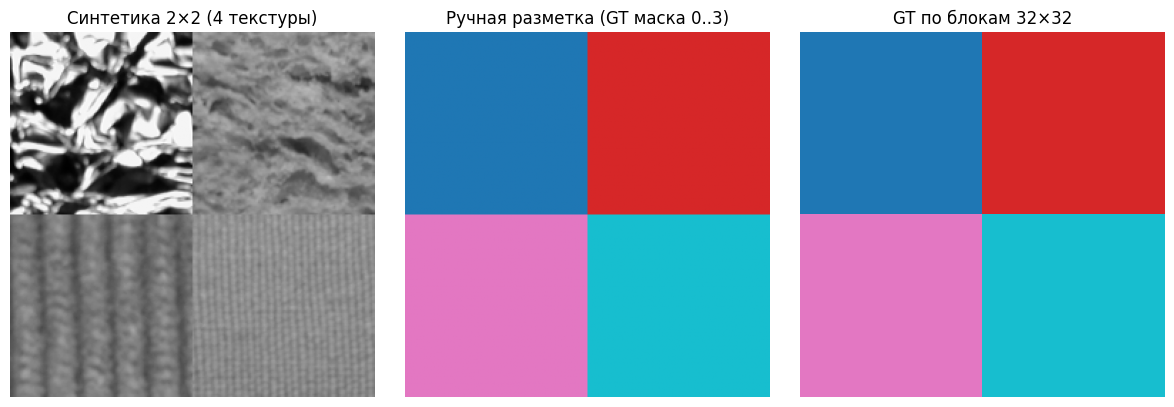

Размер синтетики: (256, 256)
Сетка блоков: (8, 8)


In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

paths_by_class = {}
for cls in os.listdir(ROOT):
    cls_path = os.path.join(ROOT, cls)
    if not os.path.isdir(cls_path):
        continue
    files = [os.path.join(cls_path, f) for f in os.listdir(cls_path)
             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
    if files:
        paths_by_class[cls] = files

classes_available = sorted(paths_by_class.keys())
print("Доступные классы:", classes_available)

C0, C1, C2, C3 = classes_available[0], classes_available[1], classes_available[2], classes_available[3]
classes_4 = [C0, C1, C2, C3]
print("Выбраны классы (квадранты):")
print("0 (верх-лево):", C0)
print("1 (верх-право):", C1)
print("2 (низ-лево):", C2)
print("3 (низ-право):", C3)

imgs = []
for cls in classes_4:
    img = cv2.imread(paths_by_class[cls][0], cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Не удалось прочитать картинку класса: " + cls)
    imgs.append(img)

# Размер синтетики
H, W = 256, 256
h2, w2 = H//2, W//2

# Делаем 4 квадранта
q0 = cv2.resize(imgs[0], (w2, h2), interpolation=cv2.INTER_AREA)  # TL
q1 = cv2.resize(imgs[1], (w2, h2), interpolation=cv2.INTER_AREA)  # TR
q2 = cv2.resize(imgs[2], (w2, h2), interpolation=cv2.INTER_AREA)  # BL
q3 = cv2.resize(imgs[3], (w2, h2), interpolation=cv2.INTER_AREA)  # BR

top = np.hstack([q0, q1])
bot = np.hstack([q2, q3])
synthetic = np.vstack([top, bot]).astype(np.uint8)

# GT маска по пикселям: значения 0..3
gt_mask = np.zeros((H, W), dtype=np.uint8)
gt_mask[0:h2, 0:w2] = 0
gt_mask[0:h2, w2:W] = 1
gt_mask[h2:H, 0:w2] = 2
gt_mask[h2:H, w2:W] = 3

# GT по блокам 32×32
tile = 32
gh, gw = H//tile, W//tile
gt_grid = np.zeros((gh, gw), dtype=np.uint8)
gt_grid[0:gh//2, 0:gw//2] = 0
gt_grid[0:gh//2, gw//2:gw] = 1
gt_grid[gh//2:gh, 0:gw//2] = 2
gt_grid[gh//2:gh, gw//2:gw] = 3

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(synthetic, cmap='gray')
plt.title("Синтетика 2×2 (4 текстуры)")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(gt_mask, cmap='tab10')
plt.title("Ручная разметка (GT маска 0..3)")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(gt_grid, cmap='tab10', interpolation='nearest')
plt.title("GT по блокам 32×32")
plt.axis('off')

plt.tight_layout()
plt.show()

print("Размер синтетики:", synthetic.shape)
print("Сетка блоков:", gt_grid.shape)


Данных для обучения (4 класса): 324
Модели обучены: RF(Hist), RF(Laws), RF(GLCM)

Точность сегментации (accuracy по блокам 32×32):
Histogram + RF: 0.8594
Laws      + RF: 0.3750
GLCM      + RF: 0.3906


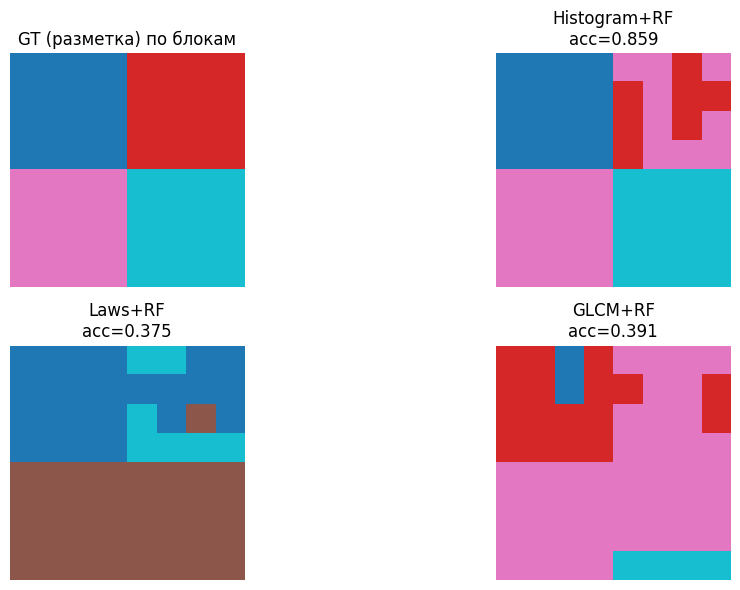


Легенда классов (0..3):
0 -> aluminium_foil
1 -> brown_bread
2 -> corduroy
3 -> cotton


In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from skimage.feature import graycomatrix, graycoprops

def hist_features(gray_img, bins=32):
    h = cv2.calcHist([gray_img], [0], None, [bins], [0, 256]).flatten()
    h = h / (h.sum() + 1e-8)
    return h.astype(np.float32)

L5 = np.array([1, 4, 6, 4, 1], dtype=np.float32)
E5 = np.array([-1, -2, 0, 2, 1], dtype=np.float32)
S5 = np.array([-1, 0, 2, 0, -1], dtype=np.float32)
W5 = np.array([-1, 2, 0, -2, 1], dtype=np.float32)
R5 = np.array([1, -4, 6, -4, 1], dtype=np.float32)
laws_1d = [L5, E5, S5, W5, R5]
laws_filters = [np.outer(a, b) for a in laws_1d for b in laws_1d]

def laws_features(gray_img):
    gray = gray_img.astype(np.float32)
    feats = []
    for k in laws_filters:
        resp = cv2.filter2D(gray, -1, k)
        feats.append(np.mean(np.abs(resp)))
    return np.array(feats, dtype=np.float32)

distances = [1, 2]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
props = ["contrast", "dissimilarity", "homogeneity", "energy", "correlation", "ASM"]

def glcm_features(gray_img):
    img = (gray_img / 16).astype(np.uint8)
    glcm = graycomatrix(img, distances=distances, angles=angles, levels=16, symmetric=True, normed=True)
    feats = []
    for p in props:
        feats.extend(graycoprops(glcm, p).flatten())
    return np.array(feats, dtype=np.float32)

class_to_idx = {cls: np.where(le.classes_ == cls)[0][0] for cls in le.classes_}
idxs = [class_to_idx[c] for c in classes_4]  

mask_4 = np.isin(y, idxs)
imgs_4 = data_imgs[mask_4]
y_4 = y[mask_4]

map_old_to_new = {idxs[i]: i for i in range(4)}
y_4_new = np.array([map_old_to_new[val] for val in y_4], dtype=np.uint8)

print("Данных для обучения (4 класса):", imgs_4.shape[0])

X_hist = np.array([hist_features(im, bins=32) for im in imgs_4], dtype=np.float32)
X_laws = np.array([laws_features(im) for im in imgs_4], dtype=np.float32)
X_glcm = np.array([glcm_features(im) for im in imgs_4], dtype=np.float32)

rf_hist = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_hist, y_4_new)
rf_laws = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_laws, y_4_new)
rf_glcm = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_glcm, y_4_new)

print("Модели обучены: RF(Hist), RF(Laws), RF(GLCM)")

tile = 32
H, W = synthetic.shape
gh, gw = H//tile, W//tile

def segment_by_tiles(img_gray, feature_func, model):
    pred_grid = np.zeros((gh, gw), dtype=np.uint8)
    for i in range(gh):
        for j in range(gw):
            patch = img_gray[i*tile:(i+1)*tile, j*tile:(j+1)*tile]
            feat = feature_func(patch).reshape(1, -1)
            pred_grid[i, j] = model.predict(feat)[0]
    return pred_grid

pred_hist = segment_by_tiles(synthetic, lambda p: hist_features(p, bins=32), rf_hist)
pred_laws = segment_by_tiles(synthetic, laws_features, rf_laws)
pred_glcm = segment_by_tiles(synthetic, glcm_features, rf_glcm)

acc_hist = accuracy_score(gt_grid.flatten(), pred_hist.flatten())
acc_laws = accuracy_score(gt_grid.flatten(), pred_laws.flatten())
acc_glcm = accuracy_score(gt_grid.flatten(), pred_glcm.flatten())

print("\nТочность сегментации (accuracy по блокам 32×32):")
print(f"Histogram + RF: {acc_hist:.4f}")
print(f"Laws      + RF: {acc_laws:.4f}")
print(f"GLCM      + RF: {acc_glcm:.4f}")

plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
plt.imshow(gt_grid, cmap='tab10', interpolation='nearest')
plt.title("GT (разметка) по блокам")
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(pred_hist, cmap='tab10', interpolation='nearest')
plt.title(f"Histogram+RF\nacc={acc_hist:.3f}")
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(pred_laws, cmap='tab10', interpolation='nearest')
plt.title(f"Laws+RF\nacc={acc_laws:.3f}")
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(pred_glcm, cmap='tab10', interpolation='nearest')
plt.title(f"GLCM+RF\nacc={acc_glcm:.3f}")
plt.axis('off')

plt.tight_layout()
plt.show()

print("\nЛегенда классов (0..3):")
for i, cls in enumerate(classes_4):
    print(i, "->", cls)


In [9]:
import pandas as pd

seg_table = pd.DataFrame(
    {
        "Histogram + RF": [acc_hist],
        "Laws + RF": [acc_laws],
        "GLCM + RF": [acc_glcm],
    },
    index=["Accuracy"]
)

print("Сравнение качества сегментации (по блокам 32×32):")
display(seg_table)


best_method = seg_table.loc["Accuracy"].idxmax()
best_value = seg_table.loc["Accuracy"].max()

print("\nЛучший метод сегментации:")
print(best_method, "->", f"{best_value:.4f}")


Сравнение качества сегментации (по блокам 32×32):


,Histogram + RF,Laws + RF,GLCM + RF
Accuracy,0.859375,0.375,0.390625



Лучший метод сегментации:
Histogram + RF -> 0.8594
